# Identifying new parents from purchases data

This is a binary classification task.

The goal of this analysis is not to develop optimized models. It is instead to evaluate whether risks are present by using simple models and our dataset, which is small in comparison to the wealth of data the larger platforms have access to.

In [54]:
import datetime

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Models etc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn import svm


# For Amazon data, make easier to access col names by defining here
RESPONSE_ID = 'Survey ResponseID'
DATE = 'Order Date'
UNIT_PRICE = 'Purchase Price Per Unit'
QUANTITY = 'Quantity'
TITLE = 'Title'
PRODUCT_CODE = 'ASIN/ISBN (Product Code)'
CATEGORY = 'Category'

# Additional information we add to the products table
GENDERED_CATEGORY = 'GENDERED CATEGORY'
RENAMED_CATEGORY = 'RENAMED CATEGORY'
FIXED_PRODUCT_CODE = 'FIXED ASIN/ISBN'

# column names specific to the notebook are lowercase
TOTAL_SPEND = 'spend' # unit price x quantity
PURCHASES = 'purchases'
PURCHASERS = 'purchasers'

YEAR = 'year'

# use a consistent random state to reproduce outputs in the models
RANDOM = 0

## Amazon data

Read in Amazon data.

In [55]:
amzn_data_fpath = '../data/amazon-data/amazon-data-cleaned.csv'
amzn_data = pd.read_csv(amzn_data_fpath, parse_dates=['Order Date'])
# convert NaNs in string columns to strings to avoid losing data in groupby/merge operations
amzn_data[PRODUCT_CODE] = amzn_data[PRODUCT_CODE].astype(str)
amzn_data[CATEGORY] = amzn_data[CATEGORY].astype(str)
amzn_data[TITLE] = amzn_data[TITLE].astype(str)
# add date columns for analysis convenience
amzn_data[YEAR] = amzn_data[DATE].apply(lambda d: d.year)
# add total spend
amzn_data[TOTAL_SPEND] = amzn_data.apply(lambda row: row[UNIT_PRICE]*row[QUANTITY], axis=1)
amzn_data.head(3)

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Category,Survey ResponseID,year,spend
0,2018-12-04,7.98,1.0,NJ,SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...,B0143RTB1E,FLASH_MEMORY,R_01vNIayewjIIKMF,2018,7.98
1,2018-12-22,13.99,1.0,NJ,Betron BS10 Earphones Wired Headphones in Ear ...,B01MA1MJ6H,HEADPHONES,R_01vNIayewjIIKMF,2018,13.99
2,2018-12-24,8.99,1.0,NJ,nan,B078JZTFN3,nan,R_01vNIayewjIIKMF,2018,8.99


In [56]:
def print_amazon_data_metrics(df):
    print('%s purchases' % len(df))
    print('%s products' % df[PRODUCT_CODE].nunique())
    print('%s categories' % df[CATEGORY].nunique())
    print('%s response Ids' % df[RESPONSE_ID].nunique())
    
print_amazon_data_metrics(amzn_data)

1850717 purchases
939083 products
1872 categories
5027 response Ids


## Get preprocessed purchases data


In [57]:
products_table_fpath = './preprocessed/products_table.csv'
products_table = pd.read_csv(products_table_fpath, index_col=0)
products_table.head()

,purchasers,Category,Title,FIXED ASIN/ISBN,MEN,WOMEN,GENDERED CATEGORY,RENAMED CATEGORY
ASIN/ISBN (Product Code),,,,,,,,
B00IX1I3G6,1157,GIFT_CARD,Amazon.com Gift Card Balance Reload,B00IX1I3G6,False,False,GIFT_CARD,GIFT_CARD
B086KKT3RX,875,ABIS_GIFT_CARD,Amazon Reload,B086KKT3RX,False,False,ABIS_GIFT_CARD,ABIS_GIFT_CARD
B07PCMWTSG,543,GIFT_CARD,Amazon.com eGift Card,B07PCMWTSG,False,False,GIFT_CARD,GIFT_CARD
B004LLIKVU,467,GIFT_CARD,Amazon.com eGift Card,B004LLIKVU,False,False,GIFT_CARD,GIFT_CARD
B07FZ8S74R,377,DIGITAL_DEVICE_3,"Echo Dot (3rd Gen, 2018 release) - Smart speak...",B07FZ8S74R,False,False,DIGITAL_DEVICE_3,DIGITAL_DEVICE_3


In [58]:
print_amazon_data_metrics(amzn_data)

1850717 purchases
939083 products
1872 categories
5027 response Ids


#### Apply the data fixups

In [59]:
print('Updating product codes')
amzn_data[PRODUCT_CODE] = amzn_data[PRODUCT_CODE].map(products_table[FIXED_PRODUCT_CODE])

Updating product codes


In [60]:
print_amazon_data_metrics(amzn_data)

1850717 purchases
937923 products
1872 categories
5027 response Ids


In [61]:
print('Updating categories with updated product codes')
amzn_data[CATEGORY] = amzn_data[PRODUCT_CODE].map(products_table[RENAMED_CATEGORY])
print_amazon_data_metrics(amzn_data)

Updating categories with updated product codes
1850717 purchases
937923 products
5580 categories
5027 response Ids


In [62]:
amzn_data[CATEGORY].value_counts().head()

Category
NAN                       89472
PET_FOOD                  38367
GIFT_CARD                 27952
NUTRITIONAL_SUPPLEMENT    25111
BOOK                      20628
Name: count, dtype: int64

---

# Survey data setup

In [63]:
# only inspect the fields of interest for this notebook
Q_life_changes = 'Q-life-changes'

demo_fields = [
    'Survey ResponseID', 
    'Q-life-changes'
]
# Here are the fields
fields_df = pd.read_csv('../data/survey-data/fields.pub.csv', index_col=0).loc[demo_fields]
fields_df

,fields
Survey ResponseID,Response ID
Q-life-changes,"In 2021 did you, or someone you share your Ama..."


In [64]:
# Read in survey data and keep only the columns to be used below
# Want ResponseId, state, and demographic data used to compare purchase behaviors and stratify
survey_data_fpath = '../data/survey-data/survey.pub.csv'
survey_df = pd.read_csv(survey_data_fpath,  usecols=demo_fields).rename(
        columns={RESPONSE_ID: RESPONSE_ID}
).set_index(RESPONSE_ID)
display(survey_df.head(3))

,Q-life-changes
Survey ResponseID,
R_1ou69fj4DQGsVcp,Lost a job
R_2UbJL30HRjK1sdD,NaN
R_UPXamGKtmf4RVIZ,NaN


In [65]:
print('The question:\n')
print(fields_df.loc[Q_life_changes].values[0])

The question:

In 2021 did you, or someone you share your Amazon account with, experience any of the following life changes?

Please mark all that apply.


Our survey asked about life changes in household in 2021, which included:
- Had a child (159; 3.2%)
- Became pregnant (145; 2.9%)



In [66]:
survey_df['Had a child'] = survey_df['Q-life-changes'].apply(lambda r: 'Had a child' in str(r))
survey_df['Became pregnant'] = survey_df['Q-life-changes'].apply(lambda r: 'Became pregnant' in str(r))

print('Of the total (unrestricted) survey participants:')
print('%s Became pregnant in 2021' % survey_df['Became pregnant'].sum())
print('%s Had a child in 2021' % survey_df['Had a child'].sum())

# was there anyone who said they had a child but not that they became pregnant?
# or the other way around?
print('%s had a child but did not become pregnant in 2021' %
    len(survey_df[(survey_df['Had a child']==True) & (survey_df['Became pregnant']==False)]))

print('%s became pregnant but did not have a child in 2021' %
    len(survey_df[(survey_df['Had a child']==False) & (survey_df['Became pregnant']==True)]))
survey_df.head(3)

Of the total (unrestricted) survey participants:
145 Became pregnant in 2021
159 Had a child in 2021
99 had a child but did not become pregnant in 2021
85 became pregnant but did not have a child in 2021


,Q-life-changes,Had a child,Became pregnant
Survey ResponseID,,,
R_1ou69fj4DQGsVcp,Lost a job,False,False
R_2UbJL30HRjK1sdD,NaN,False,False
R_UPXamGKtmf4RVIZ,NaN,False,False


## Data thresholds

1. purchases per user: How many users made sufficient number of purchases?


2. products per user: How many users purchased a sufficient number of distinct products

In [67]:
purchases_per_user = amzn_data.groupby([RESPONSE_ID])[DATE].count()

#### Products per user

In [68]:
products_per_user = amzn_data.groupby([RESPONSE_ID])[PRODUCT_CODE].nunique()

## Data and labels set up


### Make feature vectors with categories

Assume n categories for creating features

x_i = [x1, x2, ...,xn] for the n categories

One-hot-encode (was the item category ever purchased)


In [69]:
def get_category_one_hot_encoding(amzn_df, category, rids):
    """
    Returns vector representing all response IDs in preprocessed df. 
    1/0 indicates whether ResponseId ever purchased category.
    """
    return ((amzn_df[amzn_df[CATEGORY]==category]
             .groupby(RESPONSE_ID)[QUANTITY].sum() > 0)
            .reindex(rids).fillna(0).astype(int))

def get_X_one_hot_encoding_for_categories(amzn_df, cats, rids=None):
    rids = amzn_df[RESPONSE_ID].unique() if rids is None else rids
    X_dict = {c: get_category_one_hot_encoding(amzn_df, c, rids) for c in cats}
    X_dict[RESPONSE_ID] = rids
    return pd.DataFrame(X_dict).set_index(RESPONSE_ID)

In [70]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def get_auc_plot_roc(clf, X_test, y_test, ylabel, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(3,3))
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]
    probs = clf.predict_proba(X_test)
    # keep probabilities for positive outcomes only
    probs = probs[:, 1]
    # calculate auc
    auc = roc_auc_score(y_test, probs)
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    fpr, tpr, _ = roc_curve(y_test, probs)
    # plot the roc curve for the model
    ax.plot(ns_fpr, ns_tpr, linestyle='--')
    ax.plot(fpr, tpr, marker='.', label='%s; AUC=%.3f'%(ylabel, auc))
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend()
    print('ROC AUC=%.3f' % (auc))
    return auc

In [71]:
def get_auc(clf, X_test, y_test):
    probs = clf.predict_proba(X_test)
    # keep probabilities for positive outcomes only
    probs = probs[:, 1]
    return roc_auc_score(y_test, probs)

def get_auc_and_plot(clf, X_test, y_test, plot=True, axes=None):
    if not plot:
        return get_auc(clf, X_test, y_test)
    # plotting
    print('Mean accuracy: %0.4f' % clf.score(X_test, y_test))
    if axes is None:
        fig, axes = plt.subplots(1,2,figsize=(6,3))
    plt.tight_layout(pad=3)
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=axes[0], display_labels=['non-%s'%label, label])
    axes[0].set_title('Confusion matrix')
    auc = get_auc_plot_roc(clf, X_test, y_test.values, label, ax=axes[1])
    assert (auc == get_auc(clf, X_test, y_test))
    return auc

In [72]:
def get_OR_col(label=None):
    return '%s: OR' % label if label else 'OR'

def get_cat_col(label=None):
    return '%s: Categories' % label if label else 'Categories'

def get_category_features_OR(clf, label=None):
    return pd.DataFrame({
        get_cat_col(label): clf.feature_names_in_, 
        #'Log Odds': clf.coef_[0],
        get_OR_col(label): np.exp(clf.coef_[0]).round(3)
    })

def get_important_category_features(clf, label=None, pos_num=10, neg_num=10):
    """
    Returns table with pos_num top positive Categories and neg_num top negative Categories.
    """
    df = get_category_features_OR(clf, label)
    return pd.concat([
        df.sort_values(get_OR_col(label), ascending=False).head(pos_num)[[get_cat_col(label), get_OR_col(label)]],
        df.sort_values(get_OR_col(label), ascending=True).head(neg_num)[[get_cat_col(label), get_OR_col(label)]].sort_values(get_OR_col(label),ascending=False),
    ]).reset_index().drop('index', axis=1)

## Additional purchases data preprocessing

We prefix the category with 'BABY' when title has keyword indicative of maternity or baby

Reason to do this: Some categories with baby products in them are too broad. e.g.
- LEOTARD
- GROCERY

Might need to watch out for things like (VEGETABLE) Baby carrots. But the model should learn that BABY VEGETABLE is not about having a baby.


for chaging the category names:
- get products with baby keyword in title
- change their categories: prefix with 'BABY:'
    - add 'Baby Category' column to products_table
    - = 'BABY:Category' if baby, else 'Category'
    - use this to get a mapping of product code to 'Baby Category'

In [73]:
BABY_KWS = [
    'baby', 'babies', 'infant',
    'breastfeed', 'breast_pump', 'breast pump',
    'diaper',
    'prenatal',
    'pregnancy','maternity',
    'stroller',
    'pacifier',
]

# column name
BABY_CATEGORY = 'BABY CATEGORY'

def get_baby_cat(row):
    """
    Prefixes the category with 'BABY' if no keywords are in the category
    And a keyword is in the title.
    Checks category because we don't want to end up with BABY:BREAST_PUMP and BREAST_PUMP, etc
    We want this to be a merged category. Otherwise, we will drop information (where not enough purchases/products)
    """
    cat_lower = str(row[CATEGORY]).lower()
    if any([kw in cat_lower for kw in BABY_KWS]):
        return row[CATEGORY]
    title = str(row[TITLE]).lower()
    if any([kw in title for kw in BABY_KWS]):
        return 'BABY:%s'%row[CATEGORY]
    return row[CATEGORY]

products_table[BABY_CATEGORY] = products_table.apply(get_baby_cat, axis=1)

### Code the baby registry welcome box

There is a special product for owners of a baby registry: 'Baby Registry Welcome Box'

https://www.amazon.com/gp/help/customer/display.html?nodeId=GBLXVKVYG5SBG8HF
> The Welcome Box is available to customers with active Amazon Prime accounts, who create a Baby Registry, add 10 unique items from their Baby Registry Checklist and have over $10 of purchases from their registry (by themselves or others).

We code it with a special category 'BABY_REGISTRY_BOX'

In [74]:
products_table.at['B00N1NBOV2', BABY_CATEGORY] = 'BABY_REGISTRY_BOX'

In [75]:
products_table.loc['B00N1NBOV2']

purchasers                                 198
Category                               GROCERY
Title                Baby Registry Welcome Box
FIXED ASIN/ISBN                     B00N1NBOV2
MEN                                      False
WOMEN                                    False
GENDERED CATEGORY                      GROCERY
RENAMED CATEGORY                       GROCERY
BABY CATEGORY                BABY_REGISTRY_BOX
Name: B00N1NBOV2, dtype: object

In [76]:
products_table.head()

,purchasers,Category,Title,FIXED ASIN/ISBN,MEN,WOMEN,GENDERED CATEGORY,RENAMED CATEGORY,BABY CATEGORY
ASIN/ISBN (Product Code),,,,,,,,,
B00IX1I3G6,1157,GIFT_CARD,Amazon.com Gift Card Balance Reload,B00IX1I3G6,False,False,GIFT_CARD,GIFT_CARD,GIFT_CARD
B086KKT3RX,875,ABIS_GIFT_CARD,Amazon Reload,B086KKT3RX,False,False,ABIS_GIFT_CARD,ABIS_GIFT_CARD,ABIS_GIFT_CARD
B07PCMWTSG,543,GIFT_CARD,Amazon.com eGift Card,B07PCMWTSG,False,False,GIFT_CARD,GIFT_CARD,GIFT_CARD
B004LLIKVU,467,GIFT_CARD,Amazon.com eGift Card,B004LLIKVU,False,False,GIFT_CARD,GIFT_CARD,GIFT_CARD
B07FZ8S74R,377,DIGITAL_DEVICE_3,"Echo Dot (3rd Gen, 2018 release) - Smart speak...",B07FZ8S74R,False,False,DIGITAL_DEVICE_3,DIGITAL_DEVICE_3,DIGITAL_DEVICE_3


In [77]:
amzn_data_baby = amzn_data.copy()
amzn_data_baby[CATEGORY] = amzn_data_baby[PRODUCT_CODE].map(products_table[BABY_CATEGORY])

In [78]:
def get_year_prenatal_cat(row):
    cat = row[CATEGORY]
    if 'prenatal' in str(row[TITLE]).lower():
        return '%s:%s' % (row[YEAR], cat)
    return cat

def get_year_baby_box_cat(row):
    cat = row[CATEGORY]
    if cat == 'BABY_REGISTRY_BOX':
        return '%s:%s' % (row[YEAR], cat)
    return cat

amzn_data_baby[CATEGORY] = amzn_data_baby.apply(get_year_prenatal_cat, axis=1)
amzn_data_baby[CATEGORY] = amzn_data_baby.apply(get_year_baby_box_cat, axis=1)

## Cut to a subsample of the data

Cut data to 2021+2022 purchases only

Cut data to users with > 50 products purchased

In [79]:
years = [2021, 2022]
amzn_data_baby = amzn_data_baby[amzn_data_baby[YEAR].isin(years)]
print('When restricting Amazon purchases data to year(s) %s:' % years)
print_amazon_data_metrics(amzn_data_baby)
# amzn_data2021.head(3)

When restricting Amazon purchases data to year(s) [2021, 2022]:
910100 purchases
509599 products
2402 categories
4970 response Ids


In [80]:
products_per_user_baby = amzn_data_baby.groupby([RESPONSE_ID])[PRODUCT_CODE].nunique()
products_per_user_baby.describe()

count    4970.000000
mean      155.121328
std       177.694146
min         0.000000
25%        40.000000
50%       101.000000
75%       205.000000
max      2688.000000
Name: ASIN/ISBN (Product Code), dtype: float64

In [81]:
p50_users_baby = products_per_user_baby[products_per_user_baby >= 50].index.tolist()
print('N=%s : restricting data to users who purchased 50 distinct products in %s' % (len(p50_users_baby), years))

N=3497 : restricting data to users who purchased 50 distinct products in [2021, 2022]


In [82]:
p50u_amzn_data_baby = amzn_data_baby[amzn_data_baby[RESPONSE_ID].isin(p50_users_baby)]

In [83]:
cats_users_baby = p50u_amzn_data_baby.groupby(CATEGORY)[RESPONSE_ID].nunique().sort_values(ascending=False)
display(cats_users_baby.describe())

count    2391.000000
mean      162.505228
std       288.828217
min         1.000000
25%         8.000000
50%        55.000000
75%       178.000000
max      3244.000000
Name: Survey ResponseID, dtype: float64

In [84]:
# use categories that have been purchased by at least 30 users
cats_u30_baby = cats_users_baby[cats_users_baby >= 30].index.tolist()
print('%s categories purchased by at least 30 users' % len(cats_u30_baby))

1447 categories purchased by at least 30 users


## Run models

In [85]:
print(datetime.datetime.now())
X_baby = get_X_one_hot_encoding_for_categories(
    p50u_amzn_data_baby, cats_u30_baby)
print(datetime.datetime.now())

2024-07-03 17:38:48.218335
2024-07-03 17:39:21.629124


In [86]:
# set up the labels
label = 'Had a child'
labeled_y = survey_df[label].astype(int).rename(label)
y = labeled_y.loc[X_baby.index] # use consistent order for ResponseIds
train_test_split_data = train_test_split(X_baby, y, test_size=0.2, stratify=y, random_state=RANDOM)

In [87]:
print('For the participants restricted to at least 50 unique products purchased:')
print('%s: n=%s' % (label, y.sum()))

For the participants restricted to at least 50 unique products purchased:
Had a child: n=124



SVM for Had a child
Mean accuracy: 0.9700
ROC AUC=0.943


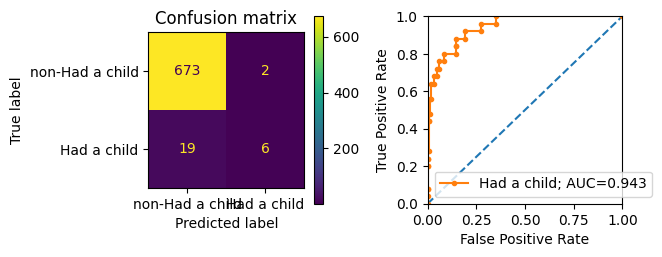

In [88]:
print('\nSVM for %s' % (label))
(X_train, X_test, y_train, y_test) = train_test_split_data
clf = svm.SVC(probability=True, class_weight='balanced', random_state=RANDOM)
clf.fit(X_train, y_train)
auc = get_auc_and_plot(clf, X_test, y_test)

In [89]:
print('AUC=%0.3f' % auc)

AUC=0.943


## Inspect results and apply interventions


Get the respondent IDs for the true positives and their indices in the test data.

Note implementation details from sklearn: https://scikit-learn.org/stable/modules/svm.html#scores-and-probabilities

> in binary classification, a sample may be labeled by predict as belonging to the positive class even if the output of predict_proba is less than 0.5; and similarly, it could be labeled as negative even if the output of predict_proba is more than 0.5.

This is the case for us.

In [90]:
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:, 1]
# get the true positives
# get their response ids and their initial prediction probabilities
tp_rids = []
tp_pred_probs = []
for i, y_pred in enumerate(y_pred):
    if (y_pred == 1) and (y_test.iloc[i]==1):
        tp_rids += [y_test.index[i]]
        tp_pred_probs += [y_pred_prob[i]]

In [91]:
print('Response IDs of the true positives (TPs) in the test sample:')
print(tp_rids)

Response IDs of the true positives (TPs) in the test sample:
['R_31TT1wA5qLC8jaX', 'R_3ez95OwZzk9mqZY', 'R_2YynbgGxQgA13bf', 'R_2pQU4najBWmK2eS', 'R_2dihfHjL0WReue6', 'R_YS4MPsfM1Neg0RH']


In [92]:
tp_pred_probs = pd.Series(tp_pred_probs, index=tp_rids)
tp_pred_probs

R_31TT1wA5qLC8jaX    0.769482
R_3ez95OwZzk9mqZY    0.679686
R_2YynbgGxQgA13bf    0.671481
R_2pQU4najBWmK2eS    0.686564
R_2dihfHjL0WReue6    0.830214
R_YS4MPsfM1Neg0RH    0.686901
dtype: float64

### How do specific categories contribute to risk?

Use logistic regression model.

- Train on all data (not train vs test).
- Get coefficients for categories (features)
- Compute odds ratios
- Extract the most informative categories (features)


In [93]:
def view_category_top_purchases(cat, num=10):
    df = amzn_data[amzn_data[CATEGORY]==cat].groupby(
        [TITLE]
    )[DATE].count().sort_values(ascending=False).to_frame()
    display(df.head(num))
    return df

In [94]:
cat = 'RICE_MIX'
_ = view_category_top_purchases(cat)

,Order Date
Title,
"Knorr Rice Sides Cheddar Broccoli Rice For a Tasty Rice Side Dish Cheddar Broccoli No Artificial Flavors, No Preservatives, No Added MSG 5.7 oz",59
"CJ Instant Rice: Cooked White Hetbahn, Gluten-Free & Vegan, Instant & Microwaveable, No Preservatives, Healthy & Delicious, 7.4 Ounce [12 Bowls] (Pack of 12)",39
"Zatarain's Spanish Rice, 6.9 oz",24
"Annie Chun's - Cooked White Sticky Rice: Instant, Microwaveable, Gluten Free, Vegan, Low Fat and Delicious, 7.4 Oz (Pack of 6)",19
Knorr Fiesta Sides For an Easy Meal with Authentic Taco Flavor Taco Rice No Artificial Flavors 5.4 oz,13
Knorr Asian Sides For a Tasty Rice Side Dish Chicken Fried Rice No Artificial Flavors 5.7 oz,13
"Knorr Rice Sides For a Tasty Rice Side Dish Chicken Long Grain Rice and Vermicelli Pasta Blend No Artificial Flavors, No Preservatives, No Added MSG 5.6 oz",11
"Yopokki Sweet & Mild Spicy Tteokbokki Pack I Korean Topokki Instant Retort Rice Cake (Pack of 2, Sweet & Mild Spicy Flavored Sauce) Korean Snack",11
"Rice-A-Roni, Rice Mix Cheddar Broccoli, 6.5 oz",11


### Inspect the data for the true positives

In [95]:
def get_category_features_OR(clf):
    return pd.DataFrame({
        CATEGORY: clf.feature_names_in_,
        'OR': np.exp(clf.coef_[0]).round(2)
    })

def get_important_category_features(clf, pos_num=10, neg_num=10):
    """
    Returns table with pos_num top positive Categories and neg_num top negative Categories.
    """
    df = get_category_features_OR(clf)
    return pd.concat([
        df.sort_values('OR', ascending=False).head(pos_num),
        df.sort_values('OR', ascending=True).head(neg_num).sort_values('OR',ascending=False),
    ]).reset_index().drop('index', axis=1)

In [96]:
print('%s: %s positive samples' % (label, y.sum()))
print('Logistic regression results for most positive and negative predictors')
lr_clf = LogisticRegression(class_weight='balanced').fit(X_baby, y)

df = get_important_category_features(lr_clf, pos_num=10, neg_num=10)
df

Had a child: 124 positive samples
Logistic regression results for most positive and negative predictors


,Category,OR
0,BABY:HAT,5.36
1,2021:BABY_REGISTRY_BOX,4.42
2,BABY_PRODUCT,4.35
3,SIM_CARD,3.06
4,SKEWER,3.04
5,SKIN_CLEANING_BRUSH,3.02
6,BABY:SECURITY_CAMERA,3.00
7,BABY:BODY_POSITIONER,2.96
8,BABY_JUMPER_WALKER,2.93
9,BABY:LEOTARD,2.61


In [97]:
category_features_OR = get_category_features_OR(lr_clf).set_index(CATEGORY)
# category_features_OR

In [98]:
# Map the ORs to the amazon data categories
amzn_data_baby['OR'] = amzn_data_baby[CATEGORY].map(category_features_OR['OR'])
amzn_data_baby[['OR', DATE, CATEGORY, TITLE, UNIT_PRICE]].head(3)

,OR,Order Date,Category,Title,Purchase Price Per Unit
89,0.60,2021-01-27,COMPUTER_DRIVE_OR_STORAGE,Seagate One Touch 2TB External Hard Drive HDD ...,62.99
90,0.76,2021-02-12,HEADPHONES,Betron BS10 Earphones Wired Headphones in Ear ...,16.45
91,0.76,2021-02-12,HEADPHONES,"Sleep Earphone for Side Sleeper,Ultra Soft Com...",12.99


In [99]:
amzn_data_baby_tp = amzn_data_baby[amzn_data_baby[RESPONSE_ID].isin(tp_rids)]
tp_total_spend = amzn_data_baby_tp.groupby(RESPONSE_ID)[TOTAL_SPEND].sum()
tp_total_spend.sort_index()

Survey ResponseID
R_2YynbgGxQgA13bf     2452.66
R_2dihfHjL0WReue6     2641.64
R_2pQU4najBWmK2eS    13844.47
R_31TT1wA5qLC8jaX     4212.89
R_3ez95OwZzk9mqZY    16112.95
R_YS4MPsfM1Neg0RH     4968.30
Name: spend, dtype: float64

How many purchases for each TP and what were there prediction probability scores?

In [100]:
# initial info:
tp_info_df = pd.DataFrame({
    RESPONSE_ID: sorted(tp_rids),
    PURCHASES: [len(amzn_data_baby[amzn_data_baby[RESPONSE_ID]==rid]) for rid in sorted(tp_rids)],
    'prediction prob.': tp_pred_probs.sort_index(),
    'total spend': tp_total_spend.sort_index(),
    'index': list(range(len(tp_rids))), # useful for keeping sorted order
}).set_index(RESPONSE_ID)
tp_info_df

,purchases,prediction prob.,total spend,index
Survey ResponseID,,,,
R_2YynbgGxQgA13bf,132,0.671481,2452.66,0
R_2dihfHjL0WReue6,137,0.830214,2641.64,1
R_2pQU4najBWmK2eS,322,0.686564,13844.47,2
R_31TT1wA5qLC8jaX,138,0.769482,4212.89,3
R_3ez95OwZzk9mqZY,705,0.679686,16112.95,4
R_YS4MPsfM1Neg0RH,188,0.686901,4968.30,5


### Apply interventions

First we confirm that making predictions on just the TPs has same impact as in the full sample.

Then we use just the TP sample.
we iterate over p in [0, 5, 10, 15, 20, ...100]
and
- remove the p most informative purchases
- run the already trained models on the modified test data

at each step we collect
- prediction probabilties
- spend differential



In [101]:
X_tp = X_baby.loc[tp_rids]
display(X_tp)
print('TP predictions:',list(clf.predict(X_tp)))
print('TP prediction probabilities', pd.Series(clf.predict_proba(X_tp)[:, 1]).round(3))

,NAN,BOOK,ELECTRONIC_CABLE,SHIRT,CELLULAR_PHONE_CASE,HEALTH_PERSONAL_CARE,HEADPHONES,NUTRITIONAL_SUPPLEMENT,CHARGING_ADAPTER,PANTS,...,KARAOKE_MACHINE,MUSICAL_INSTRUMENT_AMPLIFIER,SWIMMING_POOL,BABY:ROBE,BAKING_STONE,ANIMAL_INCONTINENCE_PROTECTOR,BABY:WEIGH_SCALE,AUDIO_OR_VIDEO,NAPKIN_HOLDER,BRAKE_ROTOR
Survey ResponseID,,,,,,,,,,,,,,,,,,,,,
R_31TT1wA5qLC8jaX,1,1,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
R_3ez95OwZzk9mqZY,1,1,0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
R_2YynbgGxQgA13bf,1,1,1,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
R_2pQU4najBWmK2eS,1,1,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
R_2dihfHjL0WReue6,1,1,0,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
R_YS4MPsfM1Neg0RH,1,1,1,1,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


TP predictions: [1, 1, 1, 1, 1, 1]
TP prediction probabilities 0    0.769
1    0.680
2    0.671
3    0.687
4    0.830
5    0.687
dtype: float64


In [102]:
def do_targeted_drops(purchases_df, p, pct):
    if pct: assert(p < 1)
    n_purchases = len(purchases_df) # set up numeric check
    purchases_df['OR'] = purchases_df[CATEGORY].map(category_features_OR['OR'])
    purchases_df = purchases_df.sort_values('OR', ascending=False)
    rids = purchases_df[RESPONSE_ID].unique()
    for i, rid in enumerate(rids):
        rid_total_purchases = len(purchases_df[purchases_df[RESPONSE_ID]==rid])
        drop_p = int(p*rid_total_purchases) if pct else p
        purchases_df = purchases_df.drop(purchases_df[purchases_df[RESPONSE_ID]==rid].index[:drop_p])
    if pct == False: assert((n_purchases - p*len(rids)) == len(purchases_df)) # numeric check
    return purchases_df

In [103]:
def get_mitigation_results(ps, pct=False):
    """
    Apply mitigation strategy to each p in ps
    if pct is True: this is a percentage of the users' total purchases
    """
    print('get mitigation results for ps: %s' % ps)
    prediction_probs = []
    spend_diffs = []
    # Sort the rids consistently
    # so that indices of spend_diffs and prediction probs match
    for p in ps: 
        print('%s: p=%s' % (datetime.datetime.now(), p))
        p_test_purchases_df = amzn_data_baby_tp.copy()
        if p > 0:
            p_test_purchases_df = do_targeted_drops(p_test_purchases_df, p, pct)
        # get spend difference
        spend_diff = tp_info_df['total spend'].sort_index() - p_test_purchases_df.groupby(RESPONSE_ID)[TOTAL_SPEND].sum()
        spend_diffs += [spend_diff.tolist()]
        p_X_test = get_X_one_hot_encoding_for_categories(p_test_purchases_df, cats_u30_baby)
        p_X_test = p_X_test.sort_index()
        prediction_probs += [list(clf.predict_proba(p_X_test)[:, 1])]

    results_df = pd.DataFrame({
        'p': ps,
        'pred. probs': prediction_probs,
        'spend diff': spend_diffs,
    }).set_index('p')
    return results_df

In [104]:
pct_p5s = [p/100 for p in range(0,100,5)]
pct_p5_results_df = get_mitigation_results(pct_p5s, pct=True)

get mitigation results for ps: [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
2024-07-03 17:39:39.245588: p=0.0
2024-07-03 17:39:39.880485: p=0.05
2024-07-03 17:39:40.514877: p=0.1
2024-07-03 17:39:41.146252: p=0.15
2024-07-03 17:39:41.777276: p=0.2
2024-07-03 17:39:42.404632: p=0.25
2024-07-03 17:39:43.031104: p=0.3
2024-07-03 17:39:43.646192: p=0.35
2024-07-03 17:39:44.270808: p=0.4
2024-07-03 17:39:44.879724: p=0.45
2024-07-03 17:39:45.484915: p=0.5
2024-07-03 17:39:46.087316: p=0.55
2024-07-03 17:39:46.686951: p=0.6
2024-07-03 17:39:47.288902: p=0.65
2024-07-03 17:39:47.891958: p=0.7
2024-07-03 17:39:48.500436: p=0.75
2024-07-03 17:39:49.095826: p=0.8
2024-07-03 17:39:49.712367: p=0.85
2024-07-03 17:39:50.295823: p=0.9
2024-07-03 17:39:50.934428: p=0.95


In [105]:
ps = list(range(0, 101, 1))
print(ps)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


In [106]:
total_p_results_df = get_mitigation_results(ps)

get mitigation results for ps: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
2024-07-03 17:39:51.586839: p=0
2024-07-03 17:39:52.222021: p=1
2024-07-03 17:39:52.858294: p=2
2024-07-03 17:39:53.536731: p=3
2024-07-03 17:39:54.175478: p=4
2024-07-03 17:39:54.810889: p=5
2024-07-03 17:39:55.442649: p=6
2024-07-03 17:39:56.130802: p=7
2024-07-03 17:39:56.767064: p=8
2024-07-03 17:39:57.421269: p=9
2024-07-03 17:39:58.093710: p=10
2024-07-03 17:39:58.731072: p=11
2024-07-03 17:39:59.368920: p=12
2024-07-03 17:40:00.062666: p=13
2024-07-03 17:40:00.702565: p=14
2024-07-03 17:40:01.338716: p=15
2024-07-03 17:40:02.019337: p=16
2024-07-03 17:40:02.64

In [107]:
total_p_results_df.head()

,pred. probs,spend diff
p,,
0,"[0.6714810075945674, 0.8302144395135218, 0.686...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,"[0.5717634636796198, 0.6761218295922719, 0.686...","[29.980000000000018, 12.989999999999782, 14.96..."
2,"[0.4815156548909143, 0.6761218295922719, 0.686...","[37.929999999999836, 24.980000000000018, 30.95..."
3,"[0.4815156548909143, 0.5722781235309045, 0.585...","[47.91999999999962, 49.9699999999998, 42.75, 7..."
4,"[0.3966554748878951, 0.4939777288220543, 0.585...","[59.909999999999854, 129.8499999999999, 58.739..."


In [109]:
pct_p5_results_df.head()

,pred. probs,spend diff
p,,
0.00,"[0.6714810075945674, 0.8302144395135218, 0.686...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
0.05,"[0.34079381118150065, 0.3951455816490911, 0.52...","[113.67999999999984, 145.27999999999975, 468.7..."
0.10,"[0.09816906334973055, 0.13760667340576754, 0.2...","[220.27999999999975, 276.1199999999999, 1092.9..."
0.15,"[0.04203856602519499, 0.029735770145109322, 0....","[327.3899999999999, 442.03999999999996, 1526.8..."
0.20,"[0.013331680229291456, 0.008670724456150615, 0...","[412.55999999999995, 554.3299999999999, 2171.5..."


In [110]:
tp_info_df.sort_values(PURCHASES, ascending=False)

,purchases,prediction prob.,total spend,index
Survey ResponseID,,,,
R_3ez95OwZzk9mqZY,705,0.679686,16112.95,4
R_2pQU4najBWmK2eS,322,0.686564,13844.47,2
R_YS4MPsfM1Neg0RH,188,0.686901,4968.30,5
R_31TT1wA5qLC8jaX,138,0.769482,4212.89,3
R_2dihfHjL0WReue6,137,0.830214,2641.64,1
R_2YynbgGxQgA13bf,132,0.671481,2452.66,0


In [111]:
xlabel = 'Excluded purchases (targeted)'

In [112]:
import matplotlib.ticker as mtick


def plot_user_spend_differential(results_df, ax=None, legend=False, p_max=None, pct=False):
    """
    Plots each user as a different dot, with consistent color
    """
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(6,2))
    plt_idx = results_df.loc[:p_max].index
    markerstyle = dict(fillstyle='none', linestyle=':', marker="o", markersize=4, alpha=1)
    if not pct:
        markerstyle = dict(linestyle='-', marker="o", markersize=2, alpha=1)
    # plot one purchaser at a time
    # iterate through respondents in order of purchases
    for i, (rid, row) in enumerate(tp_info_df.sort_values(PURCHASES, ascending=False).iterrows()):
        purchases = int(row[PURCHASES])
        index = int(row['index'])
        s_i = [vals[index] for vals in results_df.loc[:p_max]['spend diff'].values] 
        ax.plot(plt_idx, s_i, 
                label='New parent %s (%s purchases)' % (i+1, purchases),
                **markerstyle)
    ax.set_xlim(results_df.index[0], results_df.loc[:p_max].index[-1])
    if pct:
        ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}')) 
    ax.set_ylabel('Spend difference')
    ax.set_ylim(0, max(results_df.loc[:p_max].iloc[-1]['spend diff']))
    if legend: ax.legend()
    return ax   

In [113]:
def plot_user_prob_dots(results_df, ax=None, p_max=None, pct=False):
    """
    Plots each user as a different dot, with consistent color
    """
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(6,2))
    markerstyle = dict(fillstyle='none', linestyle=':', marker="o", markersize=4, alpha=1)
    if not pct:
        markerstyle = dict(linestyle='-', marker="o", markersize=2, alpha=1)
    for i, (rid, row) in enumerate(tp_info_df.sort_values(PURCHASES, ascending=False).iterrows()):
        purchases = int(row[PURCHASES])
        index = int(row['index'])
        probs_i = [vals[index] for vals in results_df.loc[:p_max]['pred. probs'].values]
        ax.plot(results_df.loc[:p_max].index, probs_i, 
                label='New parent %s (%s purchases)' % (i+1, purchases),
                **markerstyle)
    ax.set_xlim(results_df.index[0],results_df.loc[:p_max].index[-1])
    if pct:
        ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_ylim(0, 1)
    ax.set_ylabel('Prediction probability score')
    _ = ax.legend()
    return ax

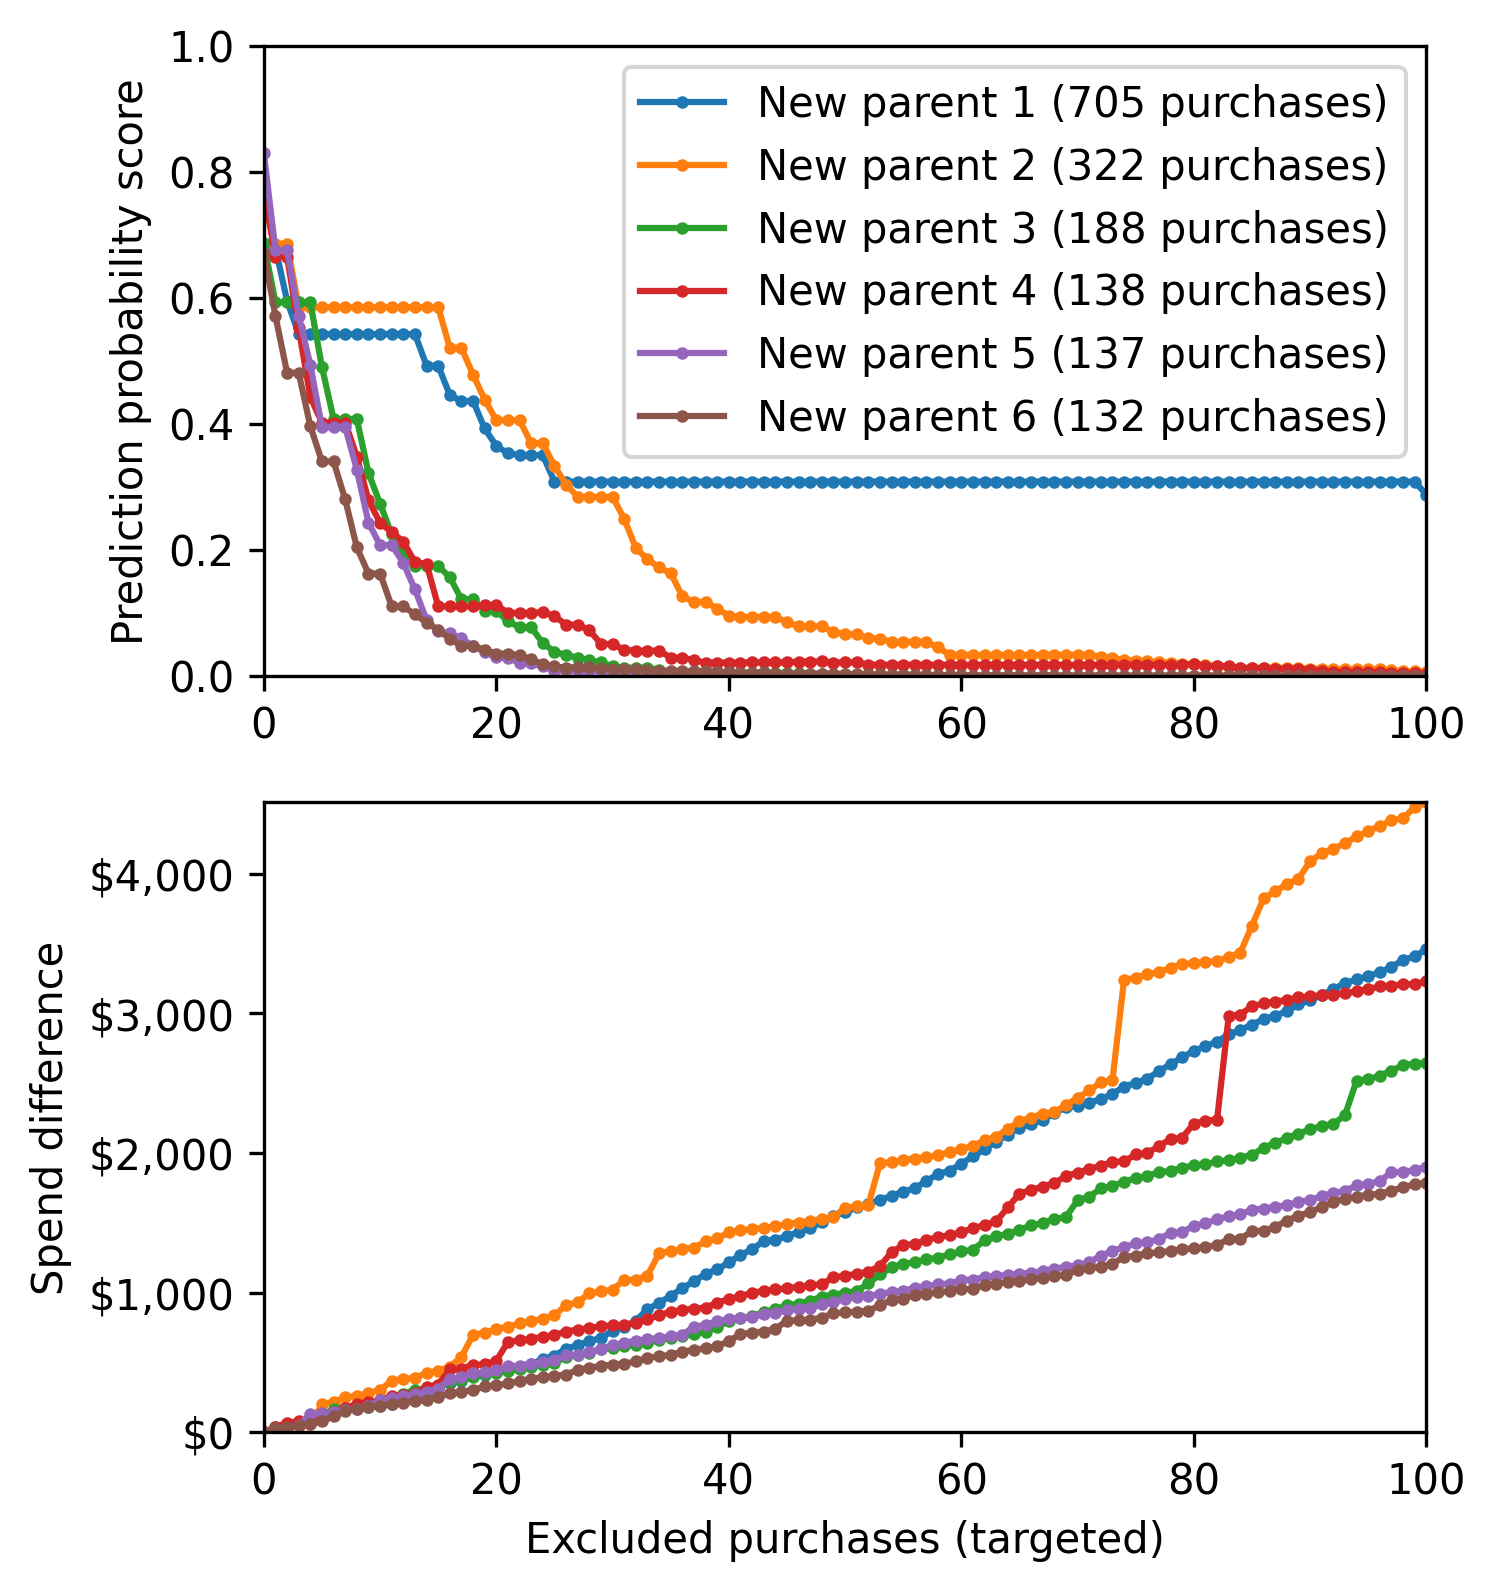

In [114]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(5,6), dpi=300)
plot_user_prob_dots(total_p_results_df, ax=ax1)
plot_user_spend_differential(total_p_results_df, ax=ax2)
_ = ax2.set_xlabel(xlabel)

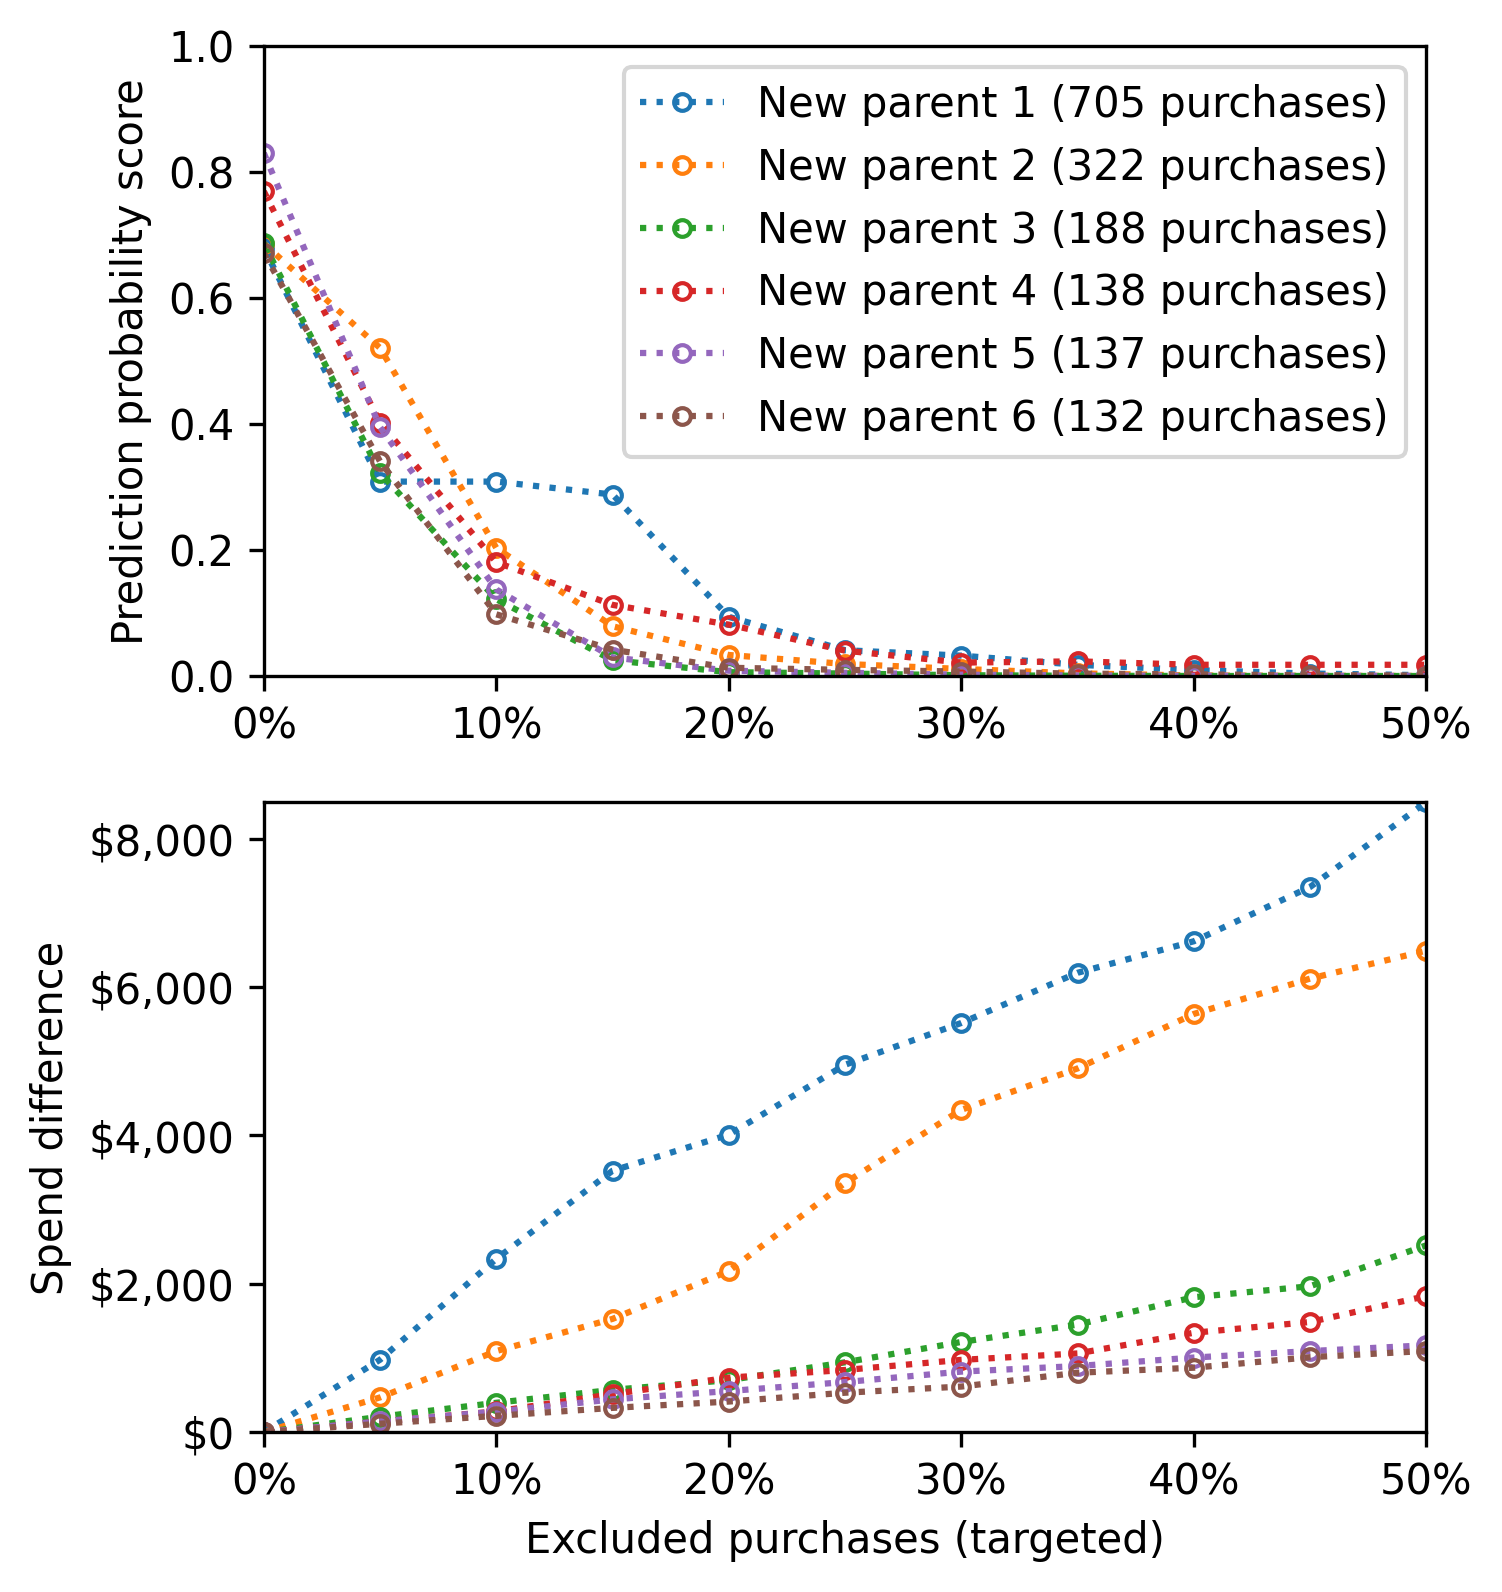

In [115]:
# plot together
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(5,6), dpi=300)
ax1 = plot_user_prob_dots(pct_p5_results_df, ax=ax1, p_max=0.5, pct=True)
ax2 = plot_user_spend_differential(pct_p5_results_df, ax=ax2, p_max=0.5, pct=True)
_ = ax2.set_xlabel('Excluded purchases (targeted)')

### Inspect quantities

In [116]:
pct_p5_results_df['max pred. probs'] = pct_p5_results_df['pred. probs'].apply(lambda probs: max(probs))

In [117]:
pct_p5_results_df.head()

,pred. probs,spend diff,max pred. probs
p,,,
0.00,"[0.6714810075945674, 0.8302144395135218, 0.686...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.830214
0.05,"[0.34079381118150065, 0.3951455816490911, 0.52...","[113.67999999999984, 145.27999999999975, 468.7...",0.520880
0.10,"[0.09816906334973055, 0.13760667340576754, 0.2...","[220.27999999999975, 276.1199999999999, 1092.9...",0.308827
0.15,"[0.04203856602519499, 0.029735770145109322, 0....","[327.3899999999999, 442.03999999999996, 1526.8...",0.288271
0.20,"[0.013331680229291456, 0.008670724456150615, 0...","[412.55999999999995, 554.3299999999999, 2171.5...",0.094161


In [118]:
tp_info_df

,purchases,prediction prob.,total spend,index
Survey ResponseID,,,,
R_2YynbgGxQgA13bf,132,0.671481,2452.66,0
R_2dihfHjL0WReue6,137,0.830214,2641.64,1
R_2pQU4najBWmK2eS,322,0.686564,13844.47,2
R_31TT1wA5qLC8jaX,138,0.769482,4212.89,3
R_3ez95OwZzk9mqZY,705,0.679686,16112.95,4
R_YS4MPsfM1Neg0RH,188,0.686901,4968.30,5


### Display most predictive categories for the TPs

Present users/new parents in the same order as the plots: sorted by total number of purchases.

In [119]:
pd.set_option('display.max_colwidth', None)
for i, rid in enumerate(tp_info_df.sort_values(PURCHASES, ascending=False).index):
    rid_amzn_df = amzn_data_baby[
        amzn_data_baby[RESPONSE_ID]==rid
    ][[DATE, TITLE, UNIT_PRICE, CATEGORY, 'OR']].sort_values('OR', ascending=False)
    total_purchases = len(rid_amzn_df)
    print(i, rid)
    print('New parent %s purchases (%s total purchases in 2021-2022)' % (i+1, total_purchases))
    rid_amzn_df['index'] = list(range(1,total_purchases+1))
    display(rid_amzn_df.set_index('index').head(5))


0 R_3ez95OwZzk9mqZY
New parent 1 purchases (705 total purchases in 2021-2022)


,Order Date,Title,Purchase Price Per Unit,Category,OR
index,,,,,
1,2022-05-09,Baby Sun Hat UPF 50+ Sun Protective Toddler Bucket Hat Summer Kids Beach Hats Wide Brim Outdoor Play Hat for Boys Girls,11.99,BABY:HAT,5.36
2,2022-05-09,Baby Sun Hat UPF 50+ Sun Protective Toddler Bucket Hat Summer Kids Beach Hats Wide Brim Outdoor Play Hat for Boys Girls,11.99,BABY:HAT,5.36
3,2021-02-08,Baby Registry Welcome Box,35.00,2021:BABY_REGISTRY_BOX,4.42
4,2021-04-26,Dekor Plus Hands-Free Diaper Pail | Gray | Easiest to Use | Just Step – Drop – Done | Doesn’t Absorb Odors | 20 Second Bag Change | Most Economical Refill System |Great for Cloth Diapers,44.95,BABY_PRODUCT,4.35
5,2021-05-12,"Kate & Milo Rustic Family Handprint Photo Frame, Family Keepsake Frame, DIY Craft for Family Night for Parents and Children, Farmhouse Decor, Distressed Wood",16.99,BABY_PRODUCT,4.35


1 R_2pQU4najBWmK2eS
New parent 2 purchases (322 total purchases in 2021-2022)


,Order Date,Title,Purchase Price Per Unit,Category,OR
index,,,,,
1,2022-03-01,"Keepersheep Baby Baseball Cap Infant Sun Hat, Infant Toddler Kids Baseball Cap",14.97,BABY:HAT,5.36
2,2022-10-15,WAOUH Boho Sunshine Hat for 1st Birthday - First Birthday Party Decor for Baby Show，Baby Hat for Handmade，Birthday Crown Cap for Baby Girls/Boys (Boho Sunshine Hat Brown),11.79,BABY:HAT,5.36
3,2022-10-19,"ZUPPAD Baby Beanie Hat 3 Packs Toddler Girls Boys, Baby Hats Winter Warm Knitted Thermal with Fleece Lining, Kids Winter Hat",15.99,BABY:HAT,5.36
4,2021-10-06,Muslin Baby Lounger Cover Soft Organic Cotton Slipcover Fits Newborn Lounger for Baby Boys and Girls (Blue),17.99,BABY_PRODUCT,4.35
5,2022-02-11,"The Play Gym by Lovevery | Stage-Based Developmental Activity Gym & Play Mat for Baby to Toddler, 1 Count (Pack of 1)",140.00,BABY_PRODUCT,4.35


2 R_YS4MPsfM1Neg0RH
New parent 3 purchases (188 total purchases in 2021-2022)


,Order Date,Title,Purchase Price Per Unit,Category,OR
index,,,,,
1,2021-05-17,Baby Registry Welcome Box,35.00,2021:BABY_REGISTRY_BOX,4.42
2,2021-06-22,"Skip Hop-Bath Toy-Storage, Moby Scoop & Splash, Blue (Discontinued by Manufacturer)",21.99,BABY_PRODUCT,4.35
3,2022-02-05,"Summer My Bath Seat for Sit-Up Baby Bathing, Backrest for Assisted Sitting, Easy Setup & Storage, Aqua",39.49,BABY_PRODUCT,4.35
4,2021-06-22,"Lansinoh TheraPearl 3-in-1 Breast Therapy Packs with Soft Covers, Hot and Cold Breast Pads for Breastfeeding Moms, 2 Pack",8.91,BABY_PRODUCT,4.35
5,2022-08-29,Bink | Award Winning Outlet Safety Plug Covers | x24 Pack (White),12.99,BABY_PRODUCT,4.35


3 R_31TT1wA5qLC8jaX
New parent 4 purchases (138 total purchases in 2021-2022)


,Order Date,Title,Purchase Price Per Unit,Category,OR
index,,,,,
1,2021-06-23,Baby Registry Welcome Box,35.00,2021:BABY_REGISTRY_BOX,4.42
2,2021-06-22,"haakaa Ladybug Breast Milk Collector - Soft Breast Shells | Wearable Nursing Cups | Breastmilk Saver| Letdown Catcher for Pumping,Breastfeeding Moms,Protect Sore Nipples(Silicone 2.5 oz/75 ml,2PK)",32.99,BABY_PRODUCT,4.35
3,2022-08-30,"Munchkin Bubble Beak Bath Spout Cover Safety Guard, Yellow, 1 Count (Pack of 1)",9.95,BABY_PRODUCT,4.35
4,2022-09-21,"Boudreaux's Butt Paste Maximum Strength Diaper Rash Cream, Ointment for Baby, 14 oz Flip-Top Jar",12.13,BABY:SKIN_PROTECTANT,2.45
5,2022-10-31,"Gerber Mealtime for Toddler Yellow Rice with Chicken & Vegetables, 6.67 Ounce (Pack of 8)",23.04,RICE_MIX,2.04


4 R_2dihfHjL0WReue6
New parent 5 purchases (137 total purchases in 2021-2022)


,Order Date,Title,Purchase Price Per Unit,Category,OR
index,,,,,
1,2022-08-26,Geyoga 6 Pieces Newborn Baby Hat Bear Ears Infant Caps Baby Boy Girl Toddler Hats Infant Beanie Caps for 0-3 Months,12.99,BABY:HAT,5.36
2,2022-09-12,"TOWOOZ Bottle Warmer, Baby Bottle Warmer USB Charging Easy to Operate Milk Warmer with LCD Digital Display Screen Lightweight Portable Bottle Warmer (Type 1)",24.99,BABY_PRODUCT,4.35
3,2022-08-23,Tummy Time Water Play Mat - Activity Play Mat for Infants 3 6 9 Months - Sensory Baby Toy Gift for Girls and Boys,11.99,BABY_PRODUCT,4.35
4,2022-11-11,"Bright Starts Disney Baby MINNIE MOUSE PeekABoo Activity Jumper with Lights and Melodies, Ages 6 months +",79.88,BABY_JUMPER_WALKER,2.93
5,2022-08-26,"Boudreaux's Butt Paste Maximum Strength Diaper Rash Cream, Ointment for Baby, 2 oz Tube",4.94,BABY:SKIN_PROTECTANT,2.45


5 R_2YynbgGxQgA13bf
New parent 6 purchases (132 total purchases in 2021-2022)


,Order Date,Title,Purchase Price Per Unit,Category,OR
index,,,,,
1,2022-02-26,Deluxe Squeeze Proof Flipping Holder (2-Pack with lids) for Food Pouches & Juice Boxes - Multipurpose - Prevent Messes & Support Self-Feeding - Easy Grasping Handles - Made in USA,14.99,BABY_PRODUCT,4.35
2,2021-04-30,"Coya Glow Body Brush for Dry and Wet Brushing, Best Long Handle Dual-Sided Brush for Exfoliating Your Skin, Effectively Reduce Cellulite and Increase Lymphatic Flow",7.95,SKIN_CLEANING_BRUSH,3.02
3,2021-11-18,"MOOB Kids Travel Pillow,Baby Head Neck & Chin Support U Shape Pillows, Travel Sleeping Essentials, Perfect for Car Airplane",11.99,BABY:BODY_POSITIONER,2.96
4,2021-11-18,MOOB Baby Pillow for Car Seat Kids Travel Neck Pillow U-Shape Protection Headrest Air Cushion Child Car Seat Head Support Children Stroller Car Seat,9.99,BABY:BODY_POSITIONER,2.96
5,2021-07-01,"Amplim Battery Operated Baby Nasal Aspirator with Manual Aspirator and 30 Hygiene Filters, FSA HSA, AMP1906, Blue",16.78,BABY:NASAL_ASPIRATOR,2.41


---

Inspect categories

In [120]:
cat = 'MOUNT_BRACKET'
cat = 'ARTIFICIAL_PLANT'
# cat = 'SKEWER'
# cat = 'VDO_DEVICES'
# cat = 'BREAST_PUMP'
# cat = 'WOMEN:BODY_POSITIONER'
cat = 'SIM_CARD'
# cat = 'PACIFIER'
# cat = 'FOOD_BIB'
# cat = 'STROLLER'
cat = 'SKEWER'
_ = view_category_top_purchases(cat)


,Order Date
Title,
MalloMe Marshmallow Roasting Sticks - Smores Skewers for Fire Pit Kit - Hot Dog Camping Accessories Campfire Marshmellow 32 Inch Long Fork - 5 Pack,10
"Bamboo Skewers, Fu Store 8 Inch Bamboo Sticks Shish Kabob Skewers,Grill, Appetizer, Fruit, Corn, Chocolate Fountain, Cocktail, Art, Set of 100 Pack,with free 10 pairs of Gloves",5
"FLYPARTY Bamboo Marshmallow Roasting Sticks with 30 Inch 5mm Thick Extra Long Heavy Duty Wooden Skewers,Roaster Barbecue S'Mores Skewers Hot Dog Forks for Camping,Party,Kebab Sausage(100 Pcs)",4
"Norpro Stainless Steel 14-Inch Skewers, Set of 6, Silver",4
"HONSHEN Turkey Lacers for Trussing Turkey,6 inches Stainless Steel metal skewers,Set of 12",3
"HOPELF 6"" Natural Bamboo Skewers for BBQ，Appetiser，Fruit，Cocktail，Kabob，Chocolate Fountain，Grilling，Barbecue，Kitchen，Crafting and Party. Φ=4mm, More Size Choices 8""/10""/12""/14""/16""/30""(100 PCS)",3
"HOPELF 8"" Natural Bamboo Skewers for BBQ，Appetiser，Fruit，Cocktail，Kabob，Chocolate Fountain，Grilling，Barbecue，Kitchen，Crafting and Party. Φ=4mm, More Size Choices 6""/10""/12""/14""/16""/30""(100 PCS)",3
"OXO Good Grips 8-Piece Corn Holder Set,Yellow,One Size",3
MalloMe Marshmallow Roasting Sticks - Smores Skewers for Fire Pit Kit - Hot Dog Camping Accessories Campfire Marshmellow 32 Inch Long Fork - 8 Pack,2
